# **Introduction**

![AmzonBanner](https://entrackr.com/wp-content/uploads/2019/02/Amazon-1-1200x600.jpg)

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.

Dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 \
Number of users: 256,059 \
Number of products: 74,258 \
Timespan: Oct 1999 - Oct 2012 \
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# **Objective:**
Given a review, determine whether the review is positive or negative?

If we look at the `Score` column we can make out that the review is positive or not by using simple if-else condition.

So for this problem, we will put our focus on to the Review/Summary text. Based on the review text we will build a prediction model and determine if a future review is positive or negative. In this problem we will apply **classification** techniques called **Logistic Regression**.

**Assumption:**
- Score 4 or 5 : Positive Review
- Score 1or 2 : Negative Review
- Score 3 : Neutral Review

# **Loading the data**

The dataset is available in two forms

1.     .csv file
2.    SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score > 3, then the recommendation wil be set to **"positive"**. Otherwise, it will be set to **"negative"**.

In [1]:
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")  #Ignoring unnecessory warnings

import sqlite3
import pandas as pd   #for data manipulation and analysis
import numpy as np    #for large and multi-dimensional arrays
import nltk        #Natural language processing tool-kit
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer #For TF-IDF
from sklearn.feature_extraction.text import CountVectorizer #For Bag of words
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords   #Stopwords corpus
from nltk.stem import PorterStemmer  #Stemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec  #For Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm #Progress Meters or Progress Bars

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,RepeatedStratifiedKFold,StratifiedKFold, train_test_split, KFold,cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from datetime import datetime as dt

# Reading Data

In [2]:
# using the SQLite Table to read data.
connection_sqlobject = sqlite3.connect("../input/amazon-fine-food-reviews/database.sqlite")

In [3]:
df = pd.read_sql_query(""" SELECT * FROM Reviews""", connection_sqlobject)

In [4]:
df.shape

(568454, 10)

Text(0, 0.5, 'Count of People')

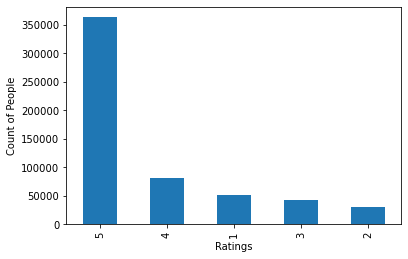

In [5]:
ax=df.Score.value_counts().plot(kind='bar')
plt.xlabel("Ratings")
plt.ylabel("Count of People")

We have 5-star rating system. It looks like we have more reviews with ratings 5, this can lead to unbalanced classes. We will treat rating 4 and 5 as positive and 3-star treat as neutral and rest as negative reviews.


filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

In [6]:
 filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", connection_sqlobject) 


#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
polarity = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['SentimentPolarity'] = polarity

labels = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
filtered_data['Class_Labels'] = labels

print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])

filtered_data.head()

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


Text(0.5, 0, 'Ratings Polarity')

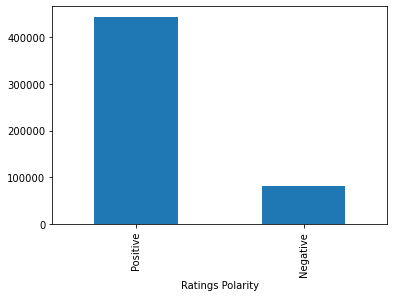

In [7]:
ax = filtered_data.SentimentPolarity.value_counts().plot(kind='bar')
plt.xlabel("Ratings Polarity")
# plt.ylabel("Count of People")

The Postive rating is quite high as compared to negative rating. If we train our algorithm with this data, there is a possibility of miss classification as my data is biased towards higher rating.

So, we have to balanced before training of dataset.

In [8]:
filtered_data['SentimentPolarity'].value_counts()

Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

In [9]:
column = 'SentimentPolarity'
filtered_data = filtered_data.groupby(column).sample(n=filtered_data[column].value_counts().min(), random_state=42)

In [10]:
filtered_data['SentimentPolarity'].value_counts()

Negative    82037
Positive    82037
Name: SentimentPolarity, dtype: int64

In [11]:
filtered_data = filtered_data.sample(frac = 0.2)

In [12]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32815 entries, 386087 to 37068
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      32815 non-null  int64 
 1   ProductId               32815 non-null  object
 2   UserId                  32815 non-null  object
 3   ProfileName             32815 non-null  object
 4   HelpfulnessNumerator    32815 non-null  int64 
 5   HelpfulnessDenominator  32815 non-null  int64 
 6   Score                   32815 non-null  int64 
 7   Time                    32815 non-null  int64 
 8   Summary                 32815 non-null  object
 9   Text                    32815 non-null  object
 10  SentimentPolarity       32815 non-null  object
 11  Class_Labels            32815 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 3.3+ MB


# **Text Preprocessing**
# Data Cleaning
**Checking duplicates**

In [13]:
# checking duplicates
filtered_data.duplicated(subset=["UserId","ProfileName","Time","Summary","Text"]).value_counts()

False    30045
True      2770
dtype: int64

As can be seen above the same user has multiple reviews at the same Time with same Summary and Text.


Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.


We first sort the data according to ProductId and then just keep the first similar product review and delete the others.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(30017, 12)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

91.47341154959622

* HelpfulnessNumerator = (Yes) Review is good or not
* HelpfulnessDenominator = (Yes + No) Review is good or not

It should be **Helpfullness Numerator is less than or equal to Helpfullness Denominator**

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


**Observation:** In Two rows the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions.

In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(30017, 12)


In [19]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

5    13006
1     9065
2     5057
4     2889
Name: Score, dtype: int64

# Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

## Removing urls from text
`re.sub(r'http\S+', '', Sentence)`

## Removing the HTML tags
`from bs4 import BeautifulSoup`
`soup = BeautifulSoup(sentence, 'lxml').get_text()`

## Removing words which contains numbers 
`re.sub("\S*\d\S*", "", sentence).strip()`

## Removing spacial character
`re.sub('[^A-Za-z0-9]+', ' ', sent_1500)

## Removing Stopwords
Stopwords are the unnecessary words that even if they are removed the sentiment of the sentence dosent change.

Ex - This pasta is so tasty ==> pasta tasty

`<br/>` these are removed
but `<br /><br />` ==> after removing HTML tag, we are getting "br br"

So, We have to include br in stopwords

## Replacing apostrophe/short words

In [20]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# stopwords = nltk.corpus.stopwords.words('english')
# stopwords.append('br')
# print(stopwords)

## Stemming & Lemmatization

| Stemming | Lemmatization |
| --- | --- |
| Stemming is faster because it chops words without knowing the context of the word in given sentences. | Lemmatization is slower as compared to stemming but it knows the context of the word before proceeding. |
| Stemming is preferred when the meaning of the word is not important for analysis. | Lemmatization would be recommended when the meaning of the word is important for analysis. |
| troubled -> troubl | troubled -> trouble |


Q) Should I perform both lemmatization and stemming?

ANS: https://stackoverflow.com/questions/49354665/should-i-perform-both-lemmatization-and-stemming

Snowball stemmer is more powerful and an updated version of Porter’s Stemmer.

https://towardsdatascience.com/stemming-corpus-with-nltk-7a6a6d02d3e5

In [23]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')

## Pre-processing on all the reviews

### Combining all the above statements

In [24]:
from tqdm import tqdm        # tqdm is for printing the status bar
preprocessed_reviews = []

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance) #removing url
    sentance = BeautifulSoup(sentance, 'lxml').get_text() # removing html tags
    sentance = decontracted(sentance) # exapnsion of words OR replacing apostrophe
    sentance = re.sub("\S*\d\S*", "", sentance).strip()  # removing alphanumeric words
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)  # removing special character
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #removing stopwords
#     sentence = ' '.join(snow.stem(word) for word in sentance) # Stemming
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 30017/30017 [00:12<00:00, 2380.55it/s]


In [25]:
preprocessed_reviews[1500]

'found gum good knowing not aspertame great flavor could lasted bit longer hoping would little mintier tasting considering no gum sugar free not aspertame know would buy gum also think price high wait till goes start chewing regularly'

In [26]:
final['Preprocessed_reviews']=preprocessed_reviews
final.head().T

,138700,138693,138699,138708,138679
Id,150518,150511,150517,150526,150497
ProductId,0006641040,0006641040,0006641040,0006641040,0006641040
UserId,AK1L4EJBA23JF,A1C9K534BCI9GO,ABW4IC5G5G8B5,A3E9QZFE9KXH8J,A1HKYQOFC8ZZCH
ProfileName,L. M. Kraus,Laura Purdie Salas,kevin clark,R. Mitchell,"Maria Apolloni ""lanarossa"""
HelpfulnessNumerator,0,0,0,11,2
HelpfulnessDenominator,0,0,0,18,2
Score,5,4,5,1,1
Time,1288224000,1344211200,1291075200,1129507200,1334707200
Summary,love this book,Charming and childlike,good for children,awesome book poor size,"The story is great, the softcover book is disa..."
Text,"Great book, perfect condition arrived in a sho...","A charming, rhyming book that describes the ci...","Classic children's book, can't go wrong. I rea...",This is one of the best children's books ever ...,I give five stars to the Maurice Sendak story....


In [27]:
positive_reviews = []
negative_reviews = []
for i in range(len(final.index)):
    if final['SentimentPolarity'].values[i] == 'Positive':
        positive_reviews.append(final['Preprocessed_reviews'].values[i])
    if final['SentimentPolarity'].values[i] == 'Negative':
        negative_reviews.append(final['Preprocessed_reviews'].values[i])

In [28]:
print("Number postive reviews",len(positive_reviews))
print("Number negative reviews",len(negative_reviews))

Number postive reviews 15895
Number negative reviews 14122


# Featurization

### Word2Vec
It takes the semantic meaning of the words and understands the relationships of the words. It also looks at the neighbors of the word in the sentence.

**TF-IDF weighted WORD2VEC**

In TF-IDF Word2Vec the Word2Vec value of each word is multiplied by the tf-idf value of that word and summed up and then divided by the sum of the tf-idf values of the sentence.

In [29]:
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split()) #splitting words

In [30]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('awesome', 0.8331654071807861), ('good', 0.8308053016662598), ('wonderful', 0.8265774250030518), ('fantastic', 0.7958822250366211), ('amazing', 0.79416823387146), ('excellent', 0.7715070247650146), ('perfect', 0.7583432793617249), ('nice', 0.6948124170303345), ('breaker', 0.6895492076873779), ('incredible', 0.6735720634460449)]
[('weakest', 0.7987540364265442), ('nastiest', 0.7839145660400391), ('best', 0.749545693397522), ('disgusting', 0.6778335571289062), ('awful', 0.6654230356216431), ('ever', 0.6241376399993896), ('terrible', 0.6207515001296997), ('horrible', 0.6136879920959473), ('honestly', 0.6085913181304932), ('eaten', 0.6062846779823303)]


In [31]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10919
sample words  ['not', 'like', 'taste', 'would', 'one', 'product', 'good', 'coffee', 'flavor', 'great', 'tea', 'no', 'food', 'get', 'love', 'really', 'amazon', 'much', 'even', 'buy', 'time', 'also', 'tried', 'use', 'little', 'dog', 'price', 'try', 'better', 'well', 'eat', 'find', 'first', 'make', 'could', 'best', 'chocolate', 'box', 'bought', 'water', 'bag', 'made', 'sugar', 'cup', 'used', 'way', 'two', 'found', 'know', 'think']


In [32]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30017/30017 [09:46<00:00, 51.20it/s]


In [34]:
# selecting a good baseline model using cross validation

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LOG', LogisticRegression()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [35]:
names = []
results = []
for name, model in models:
    fold = KFold(n_splits=10)
    score = cross_val_score(model, tfidf_sent_vectors, final['Class_Labels'], cv=fold, scoring='roc_auc')
    names.append(name)
    results.append(score)

In [36]:
plotdict = dict(zip(names, results))

for k,v in plotdict.items():
    print(f"{k}: {round(v.mean(),5)}")

KNN: 0.82011
LOG: 0.88149
DTC: 0.69618
RFC: 0.8784


AUROC Score is high for Logistic Regression.

### Selecting LogisticRegression

In [37]:
model = LogisticRegression()

In [38]:
X_train,X_test,y_train,y_test=train_test_split(tfidf_sent_vectors,final['Class_Labels'],test_size=0.3,random_state=42)

In [39]:
# fitting model
model.fit(X_train, y_train)

LogisticRegression()

In [40]:
# predicting
y_pred = model.predict(X_test)

In [41]:
score = accuracy_score(y_test, y_pred)
print("Accuracy: ", score)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print('====================================================')
print(metrics.classification_report(y_test,y_pred))

Accuracy:  0.8043526537863647
F1 score:  0.8126329221607826
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4305
           1       0.81      0.81      0.81      4701

    accuracy                           0.80      9006
   macro avg       0.80      0.80      0.80      9006
weighted avg       0.80      0.80      0.80      9006



# Hyperparameter Tuning

In [42]:
# gkf = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
cv = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)

In [43]:
# param_grid = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,10000, 50000]
#     }
# ]
penalty = ['l1', 'l2', 'elasticnet','none']
C = np.arange(0, 1, 0.001)
solver = ['lbfgs', 'newton-cg', 'liblinear', 'saga']
max_iter = range(100, 10000)
warm_start = [True, False]

random_grid ={
    'penalty' : penalty,
    'C' : C,
    'solver' : solver,
    'max_iter' : max_iter,
    'warm_start' : warm_start,
}

In [44]:
logModel = LogisticRegression()

In [45]:
# gsearch = GridSearchCV(estimator = logModel,
#                        param_grid = param_grid,
#                        scoring='f1_macro',
#                        cv = 3,
#                        verbose=4, 
#                        n_jobs=-1)

random_estimator = RandomizedSearchCV(estimator = logModel,
                                   param_distributions = random_grid,
                                   scoring = 'f1_macro',
                                   cv = cv,
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

In [46]:
best_clf = random_estimator.fit(X=X_train, y=y_train)
(random_estimator.best_params_, random_estimator.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


({'warm_start': False,
  'solver': 'lbfgs',
  'penalty': 'l2',
  'max_iter': 3656,
  'C': 0.042},
 0.8013102985207861)

In [49]:
tuned_model = LogisticRegression(penalty = 'l2',
                                 solver = 'lbfgs',
                                 C = 0.042,
                                 max_iter = 3656,
                                 warm_start=False)

tuned_model.fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_test)

In [50]:
score = accuracy_score(y_test, y_pred_tuned)
print("Accuracy: ", score)
f1score = f1_score(y_test, y_pred_tuned)
print("F1 score: ", f1score)
print('====================================================')
print(metrics.classification_report(y_test,y_pred_tuned))

Accuracy:  0.8033533200088829
F1 score:  0.8123344283140829
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      4305
           1       0.81      0.82      0.81      4701

    accuracy                           0.80      9006
   macro avg       0.80      0.80      0.80      9006
weighted avg       0.80      0.80      0.80      9006

